### Get NBA statistics

In [449]:
import pandas as pd
from nba_api.stats.endpoints import leagueleaders


first_year = 2003
last_year = 2024
leaders_df = []

for year in range(last_year-1, first_year-1, -1):
    season = "{}-{:02}".format(year, (year+1) % 100)
    leaders = leagueleaders.LeagueLeaders(per_mode48="Totals", scope="S", season=season, season_type_all_star="Regular Season")
    leaders_season_df = leaders.get_data_frames()[0]
    leaders_season_df["SEASON"] = season
    leaders_df.append(leaders_season_df.head(100))

leaders_df = pd.concat(leaders_df, ignore_index=True)

### Read targets data from csv

In [450]:
with open('target.csv') as csv_file:
    target_names_df = pd.read_csv(csv_file)
    target_names_df = target_names_df.iloc[:15, (last_year-2024):(last_year-first_year)]


leaders_df['TARGET'] = 0
for season in target_names_df:
    target_teams = target_names_df[season].to_numpy().reshape(3, 5)

    for team_idx, target_team in enumerate(target_teams):
        idxs = (leaders_df['SEASON'] == season) & leaders_df['PLAYER'].isin(target_team)
        leaders_df.loc[idxs, 'TARGET'] = 3 - team_idx

### Analyze data

In [451]:
leaders_analysis = []
for season in leaders_df['SEASON'].unique():
    season_analysis = leaders_df.loc[leaders_df['SEASON'] == season]['TARGET'].value_counts()
    leaders_analysis.append(season_analysis.rename(season))

leaders_analysis = pd.DataFrame(leaders_analysis)

### Split into train and test data

In [452]:
test_seasons = ['2007-08','2012-13','2017-18','2022-23','2023-24']

train_df = leaders_df[~leaders_df['SEASON'].isin(test_seasons)].reset_index(drop=True)

test_dfs = []
for season in test_seasons:
    test_dfs.append(leaders_df[leaders_df['SEASON'] == season].reset_index(drop=True))

### Prepare vectors of features and targets

In [453]:
from sklearn.preprocessing import MinMaxScaler


# features_all = ['PLAYER_ID', 'RANK', 'PLAYER', 'TEAM_ID', 'TEAM', 'GP', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
#                   'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'EFF']

features = ['PTS', 'FGM', 'FG3M', 'FTM', 'REB', 'EFF']
train_data = train_df[features]

scaler = MinMaxScaler()
scaler.fit_transform(train_data)

train_data_norm = scaler.transform(train_data)
train_target = train_df['TARGET'].to_numpy()

test_data_norm, test_target = [], []
for test_df in test_dfs:
    test_data = test_df[features]
    test_data_norm.append(scaler.transform(test_data))
    test_target.append(test_df['TARGET'].to_numpy())

### Visualize data

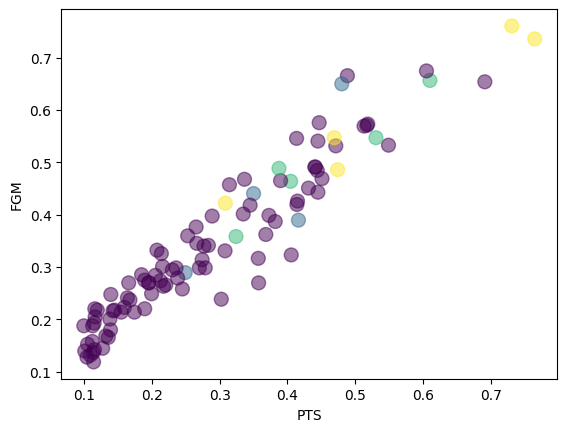

In [454]:
import matplotlib.pyplot as plt


test_season_idx = 0
feature_1_idx = 0
feature_2_idx = 1

plt.scatter(test_data_norm[test_season_idx][:, feature_1_idx], 
                           test_data_norm[test_season_idx][:, feature_2_idx], 
                           c=test_target[test_season_idx], s=100, alpha=0.5)
plt.xlabel(features[feature_1_idx])
plt.ylabel(features[feature_2_idx])
plt.show()

### Train model

In [455]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
_ = model.fit(train_data_norm, train_target)

### Test model

In [456]:
import numpy as np


for test_idx, test_df in enumerate(test_dfs):
    predictions = model.predict(test_data_norm[test_idx])
    test_df['PRED_VAL'] = predictions

    prediction_idxs = np.argsort(predictions)[::-1]

    test_df['PRED_TARGET'] = 0
    test_df.loc[prediction_idxs[:5], 'PRED_TARGET'] = 3
    test_df.loc[prediction_idxs[5:10], 'PRED_TARGET'] = 2
    test_df.loc[prediction_idxs[10:15], 'PRED_TARGET'] = 1

### Calculate predictions score

In [457]:
for test_df in test_dfs:
    test_df['SCORE'] = 0
    pts = [10, 8, 6]
    bonus_val = [0, 0, 5, 10, 20, 40]
    team_bonuses = [0, 0, 0]

    for idx, player in test_df.iterrows():
        if player['TARGET'] != 0 and player['PRED_TARGET'] != 0:
            error = int(abs(player['TARGET'] - player['PRED_TARGET']))
            test_df.loc[idx, 'SCORE'] = pts[error]

            if error == 0:
                team_bonuses[int(player['TARGET']-1)] += 1

    scores = test_df['SCORE'].to_numpy()
    bonus = sum([bonus_val[team_bonus] for team_bonus in team_bonuses])

    total_score = np.sum(scores) + bonus

    print('Season:', test_df['SEASON'].iloc[0])
    print('Score:', total_score, '\n')


Season: 2007-08
Score: 107 

Season: 2012-13
Score: 113 

Season: 2017-18
Score: 113 

Season: 2022-23
Score: 141 

Season: 2023-24
Score: 136 



### Analyse predictions

In [458]:
test_dfs[0][['PLAYER', 'TARGET', 'PRED_TARGET', 'SCORE']].sort_values(by=['TARGET', 'SCORE'], ascending=False).head(15)

,PLAYER,TARGET,PRED_TARGET,SCORE
0,Kobe Bryant,3,3,10
1,LeBron James,3,3,10
12,Dwight Howard,3,3,10
14,Chris Paul,3,2,8
42,Kevin Garnett,3,0,0
6,Dirk Nowitzki,2,2,10
28,Deron Williams,2,2,10
3,Amar'e Stoudemire,2,3,8
30,Tim Duncan,2,1,8
40,Steve Nash,2,3,8
